In [1]:
import my_plotting
import markers
import importlib
import utils
import covax_constants
import CovidVAX_specific_utils
import GeneModules

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import numpy as np

import warnings
warnings.simplefilter("ignore")

from collections import Counter
import scanpy as sc

In [2]:
adata = sc.read_h5ad(f'Monocyte CD14-2.h5ad')

In [4]:
adata.obs['subsets'] = pd.Categorical(adata.obs['new_subset_annotations_2'].map({
    'Monocyte CD14': 'CD14 ISG Low',
    'Monocyte CD14 ISG 1': 'CD14 ISG High',
    'Monocyte CD14 ISG 2': 'CD14 ISG High',
    'Monocyte CD14 ISG (Low)': 'CD14 ISG Dim',
    'Monocyte CD14 ISG Inflamm.': 'CD14 ISG High',
}),  categories=['CD14 ISG Low', 'CD14 ISG Dim', 'CD14 ISG High'])

In [5]:
adata_complete = adata.copy()
adata_complete.obs['subset_vax'] = utils.make_combined_column(adata_complete, ['subsets', 'Vaccine'])
adata_complete.obs['subset_vax'] = pd.Categorical(adata_complete.obs['subset_vax'], categories=['CD14 ISG High J&J', 'CD14 ISG High Moderna', 'CD14 ISG High Pfizer',
                                            'CD14 ISG Dim J&J', 'CD14 ISG Dim Moderna', 'CD14 ISG Dim Pfizer',
                                                 'CD14 ISG Low J&J', 'CD14 ISG Low Moderna', 'CD14 ISG Low Pfizer']
                                          )

In [6]:
adata = adata[adata.obs.Vaccine!='J&J', :].copy()

In [7]:
adata.obs['subset_vax'] = utils.make_combined_column(adata, ['subsets', 'Vaccine'])
adata.obs['subset_vax'] = pd.Categorical(adata.obs['subset_vax'], categories=['CD14 ISG High Moderna', 'CD14 ISG High Pfizer',
                                            'CD14 ISG Dim Moderna', 'CD14 ISG Dim Pfizer',
                                                 'CD14 ISG Low Moderna', 'CD14 ISG Low Pfizer']
                                          )

In [8]:
all_reasonable_genes, gene_stats = utils.filter_genes(adata, genes = 'all_reasonable', perc_exp_min=10, ubiquitous_exp_max_perc=90, groupby='subsets', use_raw=True)

df = utils.donor_level_diff_analysis(adata, all_reasonable_genes, groupby='subsets', 
                               pairs=[('CD14 ISG High', 'CD14 ISG Dim'), ('CD14 ISG High', 'CD14 ISG Low'), 
                                      ('CD14 ISG Dim', 'CD14 ISG High'), ('CD14 ISG Dim', 'CD14 ISG Low'), 
                                      ('CD14 ISG Low', 'CD14 ISG High'), ('CD14 ISG Low', 'CD14 ISG Dim')])

# high : high vs low AND high vs dim
high = df[
    (df[('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG High vs CD14 ISG Dim', 'foldchange')] > 2) &
    (df[('CD14 ISG High vs CD14 ISG Low', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG High vs CD14 ISG Low', 'foldchange')] > 2)
].sort_values(by = ('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj'))

# dim (mid) : dim vs high AND dim vs low
dim = df[
    (df[('CD14 ISG Dim vs CD14 ISG High', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Dim vs CD14 ISG High', 'foldchange')] > 1.4) &
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Dim vs CD14 ISG Low', 'foldchange')] > 1.4)
].sort_values(by = ('CD14 ISG Dim vs CD14 ISG High', 'pvalue_adj'))


# high and dim high == dim AND high > low AND mid > low
high_and_dim = df[
    (df[('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj')] > 0.1) &
    (df[('CD14 ISG High vs CD14 ISG Low', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG High vs CD14 ISG Low', 'foldchange')] > 1.5) &
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Dim vs CD14 ISG Low', 'foldchange')] > 1.5)
].sort_values(by = ('CD14 ISG Dim vs CD14 ISG Low', 'foldchange'), ascending=False)


# low (ISG Low) : low > high AND low > dim --> No such thing exists!
low = df[
    (df[('CD14 ISG Low vs CD14 ISG High', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Low vs CD14 ISG High', 'foldchange')] > 1.5) &
    (df[('CD14 ISG Low vs CD14 ISG Dim', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Low vs CD14 ISG Dim', 'foldchange')] > 1.5)
]

# dim and low; dim == low AND dim > high AND low > high
dim_and_low = df[
    (df[('CD14 ISG Dim vs CD14 ISG Low', 'pvalue_adj')] > 0.1) &
    (df[('CD14 ISG Dim vs CD14 ISG High', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Dim vs CD14 ISG High', 'foldchange')] > 1.5) &
    (df[('CD14 ISG Low vs CD14 ISG High', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Low vs CD14 ISG High', 'foldchange')] > 1.5)
].sort_values(by = ('CD14 ISG Low vs CD14 ISG High', 'pvalue_adj'))


# high and low; high == low AND high > dim AND low > dim
high_and_low = df[
    (df[('CD14 ISG High vs CD14 ISG Low', 'pvalue_adj')] > 0.1) &
    (df[('CD14 ISG High vs CD14 ISG Dim', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG High vs CD14 ISG Dim', 'foldchange')] > 1.5) &
    (df[('CD14 ISG Low vs CD14 ISG Dim', 'pvalue_adj')] < 0.01) & (df[('CD14 ISG Low vs CD14 ISG Dim', 'foldchange')] > 1.5)
]

# display(high[['CD14 ISG High vs CD14 ISG Dim', 'CD14 ISG High vs CD14 ISG Low']])
# display(dim[['CD14 ISG Dim vs CD14 ISG High', 'CD14 ISG Dim vs CD14 ISG Low']])
# display(high_and_dim[['CD14 ISG High vs CD14 ISG Low', 'CD14 ISG Dim vs CD14 ISG Low']])
# display(low.empty)
# display(dim_and_low)
# display(high_and_low.empty)

In [10]:
df.to_csv('CD14 Monocyte subsets DEG.csv')

In [8]:
picked_genes = {
    'High Specific' : high.index.tolist(), 
    'High and Dim' :  high_and_dim.index.tolist(),
    'Dim Specific' : dim.index.tolist(),
    'Dim and Low' : dim_and_low.index.tolist(),
    # 'Low Specific': low.index.tolist(),
    # 'High and Low': high_and_low.index.tolist(),
}

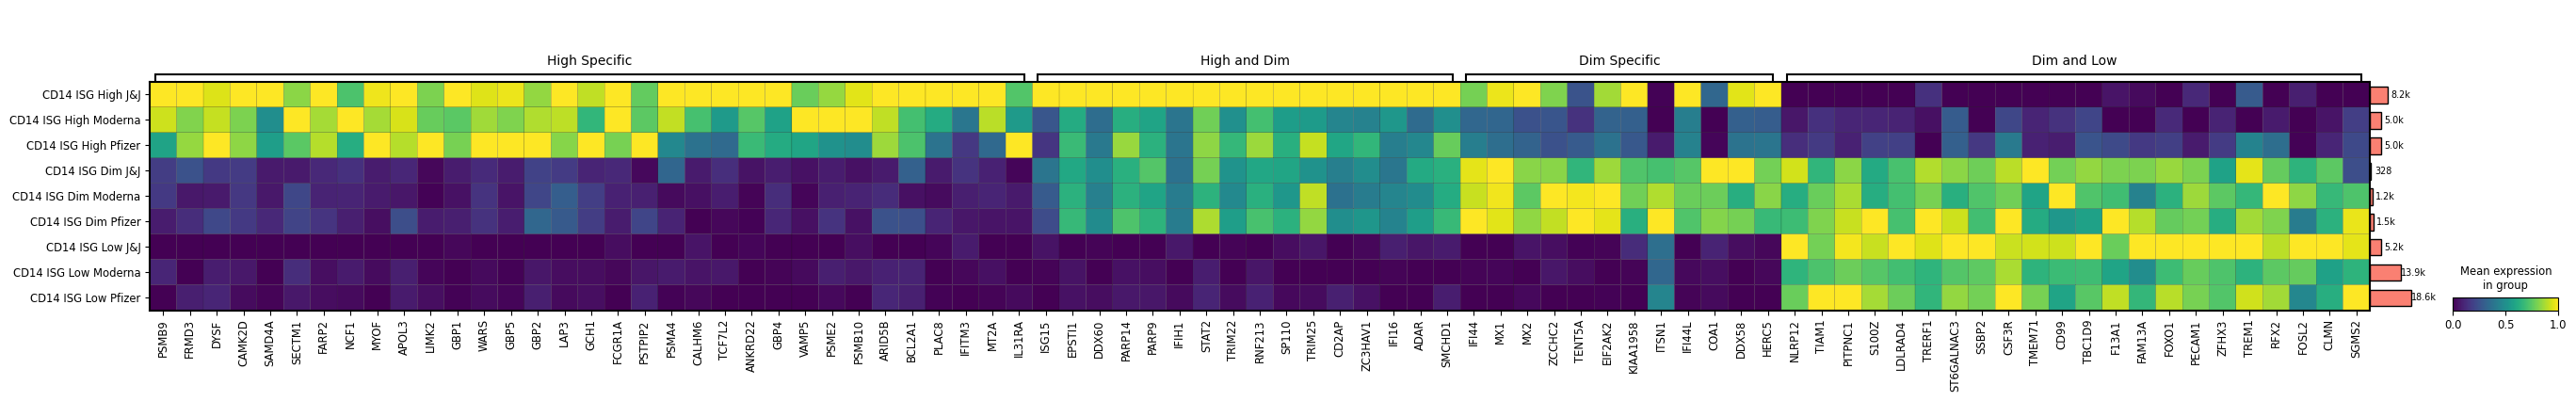

In [9]:
mp = sc.pl.matrixplot(adata_complete, 
              picked_genes,
              groupby = 'subset_vax', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True
             )

mp.add_totals().style(edge_color='black').show()
fig = mp.fig
# my_plotting.savefig_png_eps(fig, 'cd14_subsets_isg_matrixplot_2', make_folder=True, use_timestamp=False)

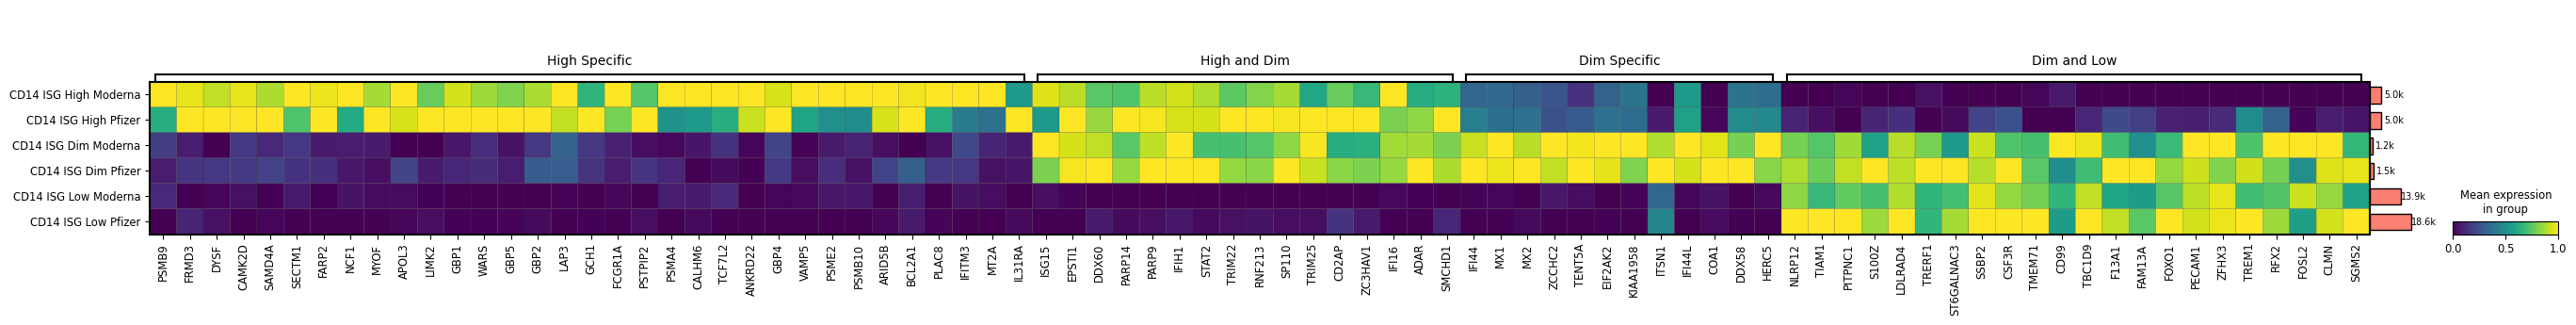

In [11]:
mp = sc.pl.matrixplot(adata, 
              picked_genes,
              groupby = 'subset_vax', 
              standard_scale = 'var',
              var_group_rotation = 0,
              return_fig=True
             )

mp.add_totals().style(edge_color='black').show()
fig = mp.fig
# my_plotting.savefig_png_eps(fig, 'cd14_subsets_isg_matrixplot_2', make_folder=True, use_timestamp=False)

In [12]:
print('{')
for key, vals in picked_genes.items():
    print(f"\t'{key}' : ", repr(vals), ',', sep='') 
print('}')

{
	'High Specific' : ['PSMB9', 'FRMD3', 'DYSF', 'CAMK2D', 'SAMD4A', 'SECTM1', 'FARP2', 'NCF1', 'MYOF', 'APOL3', 'LIMK2', 'GBP1', 'WARS', 'GBP5', 'GBP2', 'LAP3', 'GCH1', 'FCGR1A', 'PSTPIP2', 'PSMA4', 'CALHM6', 'TCF7L2', 'ANKRD22', 'GBP4', 'VAMP5', 'PSME2', 'PSMB10', 'ARID5B', 'BCL2A1', 'PLAC8', 'IFITM3', 'MT2A', 'IL31RA'],
	'High and Dim' : ['ISG15', 'EPSTI1', 'DDX60', 'PARP14', 'PARP9', 'IFIH1', 'STAT2', 'TRIM22', 'RNF213', 'SP110', 'TRIM25', 'CD2AP', 'ZC3HAV1', 'IFI16', 'ADAR', 'SMCHD1'],
	'Dim Specific' : ['IFI44', 'MX1', 'MX2', 'ZCCHC2', 'TENT5A', 'EIF2AK2', 'KIAA1958', 'ITSN1', 'IFI44L', 'COA1', 'DDX58', 'HERC5'],
	'Dim and Low' : ['NLRP12', 'TIAM1', 'PITPNC1', 'S100Z', 'LDLRAD4', 'TRERF1', 'ST6GALNAC3', 'SSBP2', 'CSF3R', 'TMEM71', 'CD99', 'TBC1D9', 'F13A1', 'FAM13A', 'FOXO1', 'PECAM1', 'ZFHX3', 'TREM1', 'RFX2', 'FOSL2', 'CLMN', 'SGMS2'],
}


In [3]:
print('IFI44', 'MX1', 'MX2', 'ZCCHC2', 'TENT5A', 'EIF2AK2', 'KIAA1958', 'ITSN1', 'IFI44L', 'COA1', 'DDX58', 'HERC5', sep = '\n')

IFI44
MX1
MX2
ZCCHC2
TENT5A
EIF2AK2
KIAA1958
ITSN1
IFI44L
COA1
DDX58
HERC5
